In [88]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt


# Read data

In [89]:
df_aps = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_phc_only_imed.parquet')

df_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_only_imed.parquet')

df_aih = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed2.parquet')



# Count warnings

In [96]:
df_aih.sum()

co_imed                                                                 17781180169
year_week                         2022-472022-482022-492022-502022-512022-522023...
warning_aih                                                                    2577
n                                                                           1803478
warning_aih_without_isolated                                                   1663
warning_aih_corect_with_consec                                                 1984
warning_final_aih                                                               556
dtype: object

In [169]:
df_aps.out_of_limits_above_phc_only.sum()

13106

In [170]:
df_otc.out_of_limits_above_otc_only.sum()

13066

In [180]:
serie1 = df_aih.groupby(['year_week'])[['warning_aih', 'warning_final_aih']].sum().reset_index()

In [181]:
serie2 = df_aps.groupby(['year_week', 'year_week_ts'])['out_of_limits_above_phc_only'].sum().reset_index()

In [182]:
serie3 = df_otc.groupby(['year_week'])['out_of_limits_above_otc_only'].sum().reset_index()

In [183]:
res1 = serie2.merge(serie1, on='year_week', how='left')

res2 = res1.merge(serie3, on='year_week', how='left')

In [184]:
res2

,year_week,year_week_ts,out_of_limits_above_phc_only,warning_aih,warning_final_aih,out_of_limits_above_otc_only
0,2022-47,2022-11-21,0,3,1,0
1,2022-48,2022-11-28,0,4,0,0
2,2022-49,2022-12-05,0,3,0,0
3,2022-50,2022-12-12,0,3,0,0
4,2022-51,2022-12-19,21,3,0,45
...,...,...,...,...,...,...
105,2024-48,2024-11-25,168,0,0,153
106,2024-49,2024-12-02,282,0,0,107
107,2024-50,2024-12-09,275,0,0,128
108,2024-51,2024-12-16,189,0,0,74


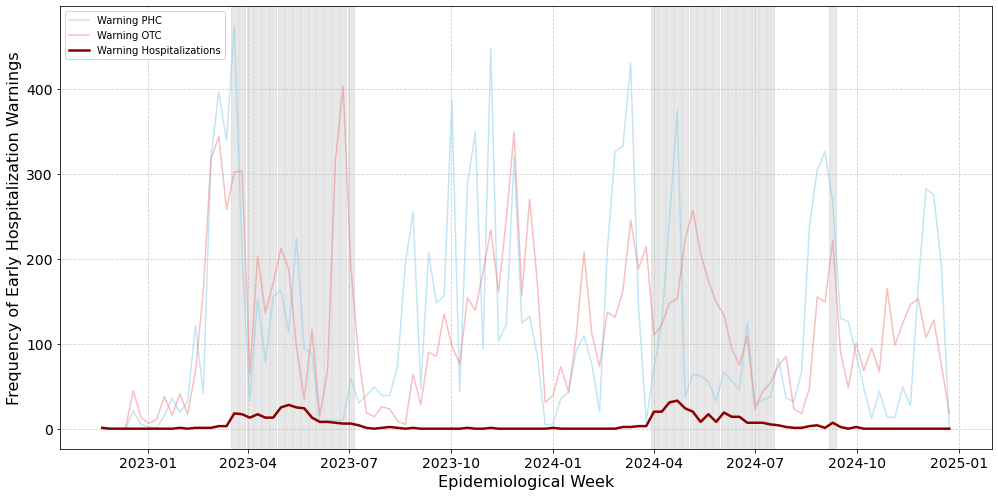

In [197]:
col_aih = 'warning_final_aih'

# Assuming 'res2' already exists and 'year_week_ts' is the date column
dates = pd.to_datetime(res2['year_week_ts'])

# Identify periods to highlight (replace with your logic to detect peaks)
# Example: Highlight weeks where warning_aih exceeds a threshold (adjust as needed)
highlight_weeks = res2[res2[col_aih] > res2[col_aih].quantile(0.7)]['year_week_ts']
highlight_weeks = pd.to_datetime(highlight_weeks)

# Plot setup
plt.figure(figsize=(14, 7))

# Plot with transparency for PHC and OTC
plt.plot(dates, res2['out_of_limits_above_phc_only'], 
         label='Warning PHC', color='skyblue', alpha=0.5, linewidth=1.5)

plt.plot(dates, res2['out_of_limits_above_otc_only'], 
         label='Warning OTC', color='lightcoral', alpha=0.5, linewidth=1.5)

# Bold line for AIH warnings
plt.plot(dates, res2[col_aih], 
         label='Warning Hospitalizations', color='darkred', linewidth=2.5)

# Add vertical highlight bands for peak weeks
for week in highlight_weeks:
    plt.axvspan(week - pd.Timedelta(days=3), week + pd.Timedelta(days=3), 
                color='lightgray', alpha=0.5)

# Format plot
plt.xlabel('Epidemiological Week', fontsize=16)
plt.ylabel('Frequency of Early Hospitalization Warnings', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.tight_layout()
plt.show()


In [198]:
res2.out_of_limits_above_otc_only.describe()

count    110.000000
mean     118.781818
std       89.875080
min        0.000000
25%       44.250000
50%      104.000000
75%      164.250000
max      403.000000
Name: out_of_limits_above_otc_only, dtype: float64

In [199]:
res2[res2.out_of_limits_above_phc_only >=  400]

,year_week,year_week_ts,out_of_limits_above_phc_only,warning_aih,warning_final_aih,out_of_limits_above_otc_only
17,2023-12,2023-03-20,473,41,18,302
50,2023-45,2023-11-06,447,3,1,234
68,2024-11,2024-03-11,430,11,2,245


In [200]:
#res2[res2.out_of_limits_above_otc_only >=  200]

In [201]:
#res2[res2['warning_aih'] > res2['warning_aih'].quantile(0.7)]['year_week_ts']

In [202]:
#res2[res2['out_of_limits_above_otc_only'] > res2['out_of_limits_above_otc_only'].quantile(0.7)]['year_week_ts']

# Counting antecipations

In [203]:
def antici_count(data_res, col_warn_s1, col_warn_s2, col_code):
    """
    Function to compute anticipated counts of warnings and missed warnings 
    across different lead times per unique region.
    
    Parameters:
    data_res (pd.DataFrame): Input DataFrame.
    col_warn_s1 (str): Column name for the primary warning signal (e.g., PHC warnings).
    col_warn_s2 (str): Column name for the secondary warning signal (e.g., AIH warnings).
    col_code (str): Column name identifying the region.

    Returns:
    pd.DataFrame: Summary DataFrame with counts of early, concurrent, and missed warnings.
    """
    
    lst_count = []

    for code in data_res[col_code].unique():
    
        dta = data_res[data_res[col_code] == code].copy()  # Use only data for the current region

        # Find sets based on PHC warnings (col_warn_s1) and AIH warnings (col_warn_s2) at different lags
        set3 = dta[(dta[col_warn_s1] == 1) & (dta[col_warn_s2].shift(-3) == 1)].index + 3
        set2 = dta[(dta[col_warn_s1] == 1) & (dta[col_warn_s2].shift(-3) == 0) & (dta[col_warn_s2].shift(-2) == 1)].index + 2
        set1 = dta[(dta[col_warn_s1] == 1) & 
                   (dta[col_warn_s2].shift(-3) == 0) & 
                   (dta[col_warn_s2].shift(-2) == 0) & 
                   (dta[col_warn_s2].shift(-1) == 1)].index + 1
        set0 = dta[(dta[col_warn_s1] == 1) & 
                   (dta[col_warn_s2] == 1) & 
                   (dta[col_warn_s2].shift(-3) == 0) & 
                   (dta[col_warn_s2].shift(-2) == 0) & 
                   (dta[col_warn_s2].shift(-1) == 0)].index

        # Warnings in PHC right after an AIH warning (possibly not anticipated but concurrent)
        set1_after = dta[(dta[col_warn_s1].shift(-1) == 1) & (dta[col_warn_s2] == 1)].index

        # Compute counts of warnings at different lead times
        n3 = len(set3)
        n2 = len(set(set2) - set(set3))
        n1 = len((set(set1) - set(set3)) - set(set2))
        n0 = len(((set(set0) - set(set3)) - set(set2)) - set(set1))
        n1_after = len((((set(set1_after) - set(set3)) - set(set2)) - set(set1)) - set(set0))

        # Drop all anticipated and concurrent warnings to count missed ones
        ind_drop = set(set3) | set(set2) | set(set1) | set(set0) | set(set1_after)
        missed = dta.drop(index=ind_drop)[col_warn_s2].sum()

        # Create the results dictionary for this region
        data = {
            col_code: [code],
            'n3': [n3],
            'n2': [n2],
            'n1': [n1],
            'n0': [n0],
            'n1_after': [n1_after],
            'missed': [missed],
            'total_aih_warning': [dta[col_warn_s2].sum()]
        }

        # Append to results list
        data_output = pd.DataFrame(data)
        lst_count.append(data_output)

    # Combine all results into a single DataFrame
    df_warning_count = pd.concat(lst_count, ignore_index=True)
    
    return df_warning_count


In [204]:
def sen_spe(df,warning_local_health, col):
    # Calculate True Positives, False Negatives, True Negatives, and False Positives
    TP = ((df[warning_local_health] == 1) & (df[col] == 1)).sum()
    FN = ((df[warning_local_health] == 1) & (df[col] == 0)).sum()
    TN = ((df[warning_local_health] == 0) & (df[col] == 0)).sum()
    FP = ((df[warning_local_health] == 0) & (df[col] == 1)).sum()

    # Calculate Sensitivity and Specificity
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    return sensitivity, specificity

### APS e AIH

In [209]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [210]:
df_warning_count = antici_count(result, 'out_of_limits_above_phc_only', 'warning_final_aih', 'co_imed')

In [211]:
#Total warning aih
df_warning_count.total_aih_warning.sum()

556

In [212]:
# 1 to 3 weeks early

print(df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum(), 
      round((df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum(),1))

302 54.3


In [213]:
# 0 to 1 week after

print(df_warning_count.n0.sum() + df_warning_count.n1_after.sum(), 
      round((df_warning_count.n0.sum() + df_warning_count.n1_after.sum())*100/df_warning_count.total_aih_warning.sum(),1))

81 14.6


In [214]:
# Missed

print(df_warning_count.missed.sum(), 
      round(df_warning_count.missed.sum()*100/df_warning_count.total_aih_warning.sum(),1))

173 31.1


In [215]:
TP = df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum() + df_warning_count.n0.sum()

Se = TP*100/df_warning_count.total_aih_warning.sum()

Se_3_1 = (df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum() 


In [216]:
Se

62.76978417266187

In [217]:
sen_spe(result,'warning_final_aih', 'out_of_limits_above_phc_only')

(0.2949640287769784, 0.7667722378065334)

### OTC and AIH

In [140]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [141]:
df_warning_count = antici_count(result, 'out_of_limits_above_otc_only', 'warning_aih', 'co_imed')

In [142]:
df_warning_count.to_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/timing_otc_aih.parquet')

In [143]:
#Total warning aih
df_warning_count.total_aih_warning.sum()

2577

In [144]:
# 1 to 3 weeks early

print(df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum(), 
      round((df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum(),1))

1238 48.0


In [145]:
# 0 to 1 week after

print(df_warning_count.n0.sum() + df_warning_count.n1_after.sum(), 
      round((df_warning_count.n0.sum() + df_warning_count.n1_after.sum())*100/df_warning_count.total_aih_warning.sum(),1))

401 15.6


In [146]:
# Missed

print(df_warning_count.missed.sum(), 
      round(df_warning_count.missed.sum()*100/df_warning_count.total_aih_warning.sum(),1))

938 36.4


In [147]:
TP = df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum() + df_warning_count.n0.sum()

Se = TP*100/df_warning_count.total_aih_warning.sum()

Se_3_1 = (df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum() 


In [148]:
Se

51.726814124951495

In [149]:
sen_spe(result,'warning_aih', 'out_of_limits_above_otc_only')

(0.2801707411719053, 0.7692264342337604)

In [150]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_aih_corect_with_consec']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [151]:
df_warning_count = antici_count(result, 'out_of_limits_above_otc_only', 'warning_aih_corect_with_consec', 'co_imed')

In [152]:
#Total warning aih
df_warning_count.total_aih_warning.sum()

1984

In [153]:
# 1 to 3 weeks early

print(df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum(), 
      round((df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum(),1))

813 41.0


In [154]:
# 0 to 1 week after

print(df_warning_count.n0.sum() + df_warning_count.n1_after.sum(), 
      round((df_warning_count.n0.sum() + df_warning_count.n1_after.sum())*100/df_warning_count.total_aih_warning.sum(),1))

352 17.7


In [155]:
# Missed

print(df_warning_count.missed.sum(), 
      round(df_warning_count.missed.sum()*100/df_warning_count.total_aih_warning.sum(),1))

819 41.3


In [156]:
TP = df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum() + df_warning_count.n0.sum()

Se = TP*100/df_warning_count.total_aih_warning.sum()

Se_3_1 = (df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum() 


In [157]:
Se

42.69153225806452

In [158]:
sen_spe(result,'warning_aih_corect_with_consec', 'out_of_limits_above_otc_only')

(0.2762096774193548, 0.7685362364612555)

In [159]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [160]:
df_warning_count = antici_count(result, 'out_of_limits_above_otc_only', 'warning_final_aih', 'co_imed')

In [161]:
#Total warning aih
df_warning_count.total_aih_warning.sum()

556

In [162]:
# 1 to 3 weeks early

print(df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum(), 
      round((df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum(),1))

355 63.8


In [163]:
# 0 to 1 week after

print(df_warning_count.n0.sum() + df_warning_count.n1_after.sum(), 
      round((df_warning_count.n0.sum() + df_warning_count.n1_after.sum())*100/df_warning_count.total_aih_warning.sum(),1))

75 13.5


In [164]:
# Missed

print(df_warning_count.missed.sum(), 
      round(df_warning_count.missed.sum()*100/df_warning_count.total_aih_warning.sum(),1))

126 22.7


In [165]:
TP = df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum() + df_warning_count.n0.sum()

Se = TP*100/df_warning_count.total_aih_warning.sum()

Se_3_1 = (df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum() 


In [166]:
Se

70.32374100719424

In [167]:
sen_spe(result,'warning_final_aih', 'out_of_limits_above_otc_only')

(0.30035971223021585, 0.7676228395620306)

## OTC and APS

In [213]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [216]:
df_warning_count = antici_count(result, 'out_of_limits_above_otc_only', 'out_of_limits_above_phc_only', 'co_imed')

In [218]:
df_warning_count

,co_imed,n3,n2,n1,n0,n1_after,missed,total_aih_warning
0,120003,5,3,0,1,6,5,20
1,120004,4,4,0,0,8,2,18
2,270002,2,0,0,2,6,9,19
3,130007,4,1,0,2,6,8,21
4,160002,5,1,0,2,9,7,24
...,...,...,...,...,...,...,...,...
505,420023,3,2,0,1,5,8,19
506,350005,4,4,1,0,4,8,21
507,350039,6,1,2,1,8,2,20
508,350042,11,0,1,1,5,14,32


In [219]:
# 1 to 3 weeks early

print(df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum(), 
      round((df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum(),1))

3849 37.1


In [220]:
# 0 to 1 week after

print(df_warning_count.n0.sum() + df_warning_count.n1_after.sum(), 
      round((df_warning_count.n0.sum() + df_warning_count.n1_after.sum())*100/df_warning_count.total_aih_warning.sum(),1))

2767 26.7


In [221]:
# Missed

print(df_warning_count.missed.sum(), 
      round(df_warning_count.missed.sum()*100/df_warning_count.total_aih_warning.sum(),1))

3760 36.2


In [222]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [223]:
df_warning_count = antici_count(result, 'out_of_limits_above_phc_only', 'out_of_limits_above_otc_only', 'co_imed')

In [224]:
df_warning_count

,co_imed,n3,n2,n1,n0,n1_after,missed,total_aih_warning
0,120003,7,1,1,1,4,8,22
1,120004,8,2,0,1,7,2,20
2,270002,8,2,1,0,2,7,20
3,130007,8,3,0,0,3,10,24
4,160002,9,2,0,0,7,3,21
...,...,...,...,...,...,...,...,...
505,420023,3,0,2,0,4,12,21
506,350005,7,1,2,0,3,8,21
507,350039,12,1,0,0,5,6,24
508,350042,10,1,0,0,6,5,22


In [225]:
# 1 to 3 weeks early

print(df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum(), 
      round((df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum())*100/df_warning_count.total_aih_warning.sum(),1))

4357 39.8


In [226]:
# 0 to 1 week after

print(df_warning_count.n0.sum() + df_warning_count.n1_after.sum(), 
      round((df_warning_count.n0.sum() + df_warning_count.n1_after.sum())*100/df_warning_count.total_aih_warning.sum(),1))

2527 23.1


In [227]:
# Missed

print(df_warning_count.missed.sum(), 
      round(df_warning_count.missed.sum()*100/df_warning_count.total_aih_warning.sum(),1))

4053 37.1


# Metrics of peformance

In [249]:
def sen_spe(df,warning_local_health, col):
    # Calculate True Positives, False Negatives, True Negatives, and False Positives
    TP = ((df[warning_local_health] == 1) & (df[col] == 1)).sum()
    FN = ((df[warning_local_health] == 1) & (df[col] == 0)).sum()
    TN = ((df[warning_local_health] == 0) & (df[col] == 0)).sum()
    FP = ((df[warning_local_health] == 0) & (df[col] == 1)).sum()

    # Calculate Sensitivity and Specificity
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    return sensitivity, specificity, round(TP*100/df[warning_local_health].sum(),1)

In [287]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [288]:
#teste1 = result.groupby(['co_imed'])['warning_aih'].sum().reset_index()
#lst = teste1[teste1.warning_aih == 0].co_imed.to_list()
#result = result[~result.co_imed.isin(lst)]

In [289]:
sen_spe(result,'warning_aih', 'out_of_limits_above_phc_only')

(0.21872909698996656, 0.7702928200790912, 21.9)

In [290]:
sen_spe(result,'warning_aih', 'out_of_limits_above_otc_only')

(0.2909698996655518, 0.7599378243079525, 29.1)

In [291]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_aih_corect_with_consec']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [292]:
#teste2 = result.groupby(['co_imed'])['warning_aih_corect_with_consec'].sum().reset_index()
#lst = teste1[teste1.warning_aih == 0].co_imed.to_list()
#result = result[~result.co_imed.isin(lst)]

In [293]:
sen_spe(result,'warning_aih_corect_with_consec', 'out_of_limits_above_phc_only')

(0.21739130434782608, 0.7703693644758284, 21.7)

In [294]:
sen_spe(result,'warning_aih_corect_with_consec', 'out_of_limits_above_otc_only')

(0.2882797731568998, 0.759369907658881, 28.8)

In [295]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [282]:
#teste2 = result.groupby(['co_imed'])['warning_final_aih'].sum().reset_index()
#lst = teste1[teste1.warning_aih == 0].co_imed.to_list()
#result = result[~result.co_imed.isin(lst)]

In [296]:
sen_spe(result,'warning_final_aih', 'out_of_limits_above_phc_only')

(0.3148148148148148, 0.7712720958190481, 31.5)

In [297]:
sen_spe(result,'warning_final_aih', 'out_of_limits_above_otc_only')

(0.30246913580246915, 0.7586936194843937, 30.2)

# Metrics of peformance 

In [299]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [ ]:
# General

TP = n0

FN = 

In [ ]:
#1 to 3 weeks early 

TP = n3 + n2 + n1

FN = n0 + n1_after + missed

sensitivity = TP / (TP + FN)

In [ ]:
def sen_spe(df,warning_local_health, col):
    # Calculate True Positives, False Negatives, True Negatives, and False Positives
    TP = ((df[warning_local_health] == 1) & (df[col] == 1)).sum()
    FN = ((df[warning_local_health] == 1) & (df[col] == 0)).sum()
    TN = ((df[warning_local_health] == 0) & (df[col] == 0)).sum()
    FP = ((df[warning_local_health] == 0) & (df[col] == 1)).sum()

    # Calculate Sensitivity and Specificity
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    return sensitivity, specificity, round(TP*100/df[warning_local_health].sum(),1)